In [18]:
#Libraries
import h5py
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from datetime import datetime
import subprocess
from scipy.ndimage import gaussian_filter

In [19]:
file_path = 'C:/Users/badar/Desktop/VS Studio/Deep Learning/PoroTomo_A3/PoroTomo DASH'

# List all files in the specified path
if os.path.exists(file_path):
    print(f"Files in directory '{file_path}':")
    for file_name in os.listdir(file_path):
        print(file_name)
else:
    print(f"Directory not found: {file_path}")

Files in directory 'C:/Users/badar/Desktop/VS Studio/Deep Learning/PoroTomo_A3/PoroTomo DASH':
Assessment 3 - PoroTomo_data.ipynb
PoroTomo_6_2_Metadata_DAS_Trenched.csv
PoroTomo_iDAS16043_160321073721.h5
PoroTomo_iDAS16043_160321073751.h5


In [20]:
# Path to the HDF5 file
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # List all groups and datasets within the file
    print("Groups and datasets within the HDF5 file:")
    for name in f:
        print(name)

Groups and datasets within the HDF5 file:
DasMetadata
DasRawData


In [21]:
with h5py.File(file_path, 'r') as f:
    raw_data = f['DasRawData/RawData'][:]
    timestamps = f['DasRawData/DasTimeArray'][:]

In [22]:
# Initialize an empty list to store data streams
data_stream = []

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Load datasets once
    raw_data = f['DasRawData/RawData'][:]
    
    # Append data to data_stream and print the keys in the file
    for i in np.arange(2):
        data_stream.append(raw_data)
        print(list(f.keys()))

# Verify the data_stream content
for i, data in enumerate(data_stream):
    print(f"Data stream {i} shape: {data.shape}")

['DasMetadata', 'DasRawData']
['DasMetadata', 'DasRawData']
Data stream 0 shape: (30000, 8721)
Data stream 1 shape: (30000, 8721)


In [23]:
# Print shapes of the datasets for verification

# Check lengths of the datasets
raw_data_len = len(raw_data)
time_len = len(timestamps)

print(f"Length of RawData: {raw_data_len}")
print(f"Length of Time: {time_len}")

# Ensure lengths match
if raw_data_len!= time_len:
    raise ValueError("Length of RawData and Time do not match!")

Length of RawData: 30000
Length of Time: 30000


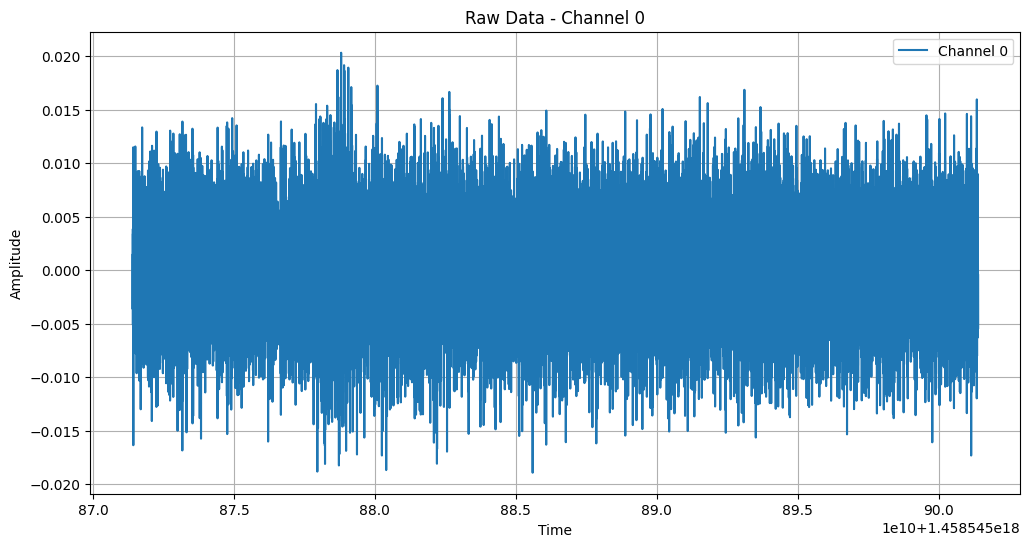

In [24]:
import matplotlib.pyplot as plt

# Example plotting for raw data
plt.figure(figsize=(12, 6))
plt.plot(timestamps, raw_data[:, 0], label='Channel 0')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Raw Data - Channel 0')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# statistical analysis
mean_data = np.mean(raw_data, axis=0)
std_data = np.std(raw_data, axis=0)
correlation_matrix = np.corrcoef(raw_data.T)

#print(mean_data)
#print(std_data)
print(correlation_matrix)

[[ 1.00000000e+00  9.37223616e-01  8.77675253e-01 ... -6.51530564e-03
  -1.12861136e-04 -1.90172285e-03]
 [ 9.37223616e-01  1.00000000e+00  9.42269337e-01 ... -5.08412365e-03
  -9.44165190e-04 -2.42774177e-03]
 [ 8.77675253e-01  9.42269337e-01  1.00000000e+00 ... -1.13565135e-02
  -6.42552684e-03 -7.93402503e-03]
 ...
 [-6.51530564e-03 -5.08412365e-03 -1.13565135e-02 ...  1.00000000e+00
   8.37682809e-01  6.83121884e-01]
 [-1.12861136e-04 -9.44165190e-04 -6.42552684e-03 ...  8.37682809e-01
   1.00000000e+00  8.63406556e-01]
 [-1.90172285e-03 -2.42774177e-03 -7.93402503e-03 ...  6.83121884e-01
   8.63406556e-01  1.00000000e+00]]


In [ ]:
import h5py
import numpy as np
import datetime
import matplotlib.pyplot as plt

### Set parameters ###############################################################

# Name of file to load
file = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Gauge length to apply if data is 'elocity' datatype
gauge_length = 0.90  # (meters)

##########################################################################################

def load_hdf_slice(file, t_start=None, t_duration=None, x_start=None, x_stop=None, info=True):
    """
        Loads data and metadata from.hdf5 file. Optionally slices data in time and space.

        Args:
            file_path: hdf5 file path.
            t_start: Time from start of data to begin slice (s)
            t_duration: Length of desired data slice (s)
            x_start: Start fibre distance from front of Treble (m)
            x_stop: Stop fibre distance from front of Treble (m)

        Returns:
            data: Sliced data array.
            metadata: Attributes of hdf file.
            timestamps: Sliced timestamp vector.
            distances: Sliced distance vector.

        """
    print(f"Loading: {file}")

    with h5py.File(file, 'r') as f:
        # Load datasets
        raw_data = f['DasRawData/RawData'][:]
        if "DasRawData/DasTimeArray" in f.keys():
            time = f['DasRawData/DasTimeArray'][:]
        else:
            print("Using Computer Time, either because no GPS data was recorded or this is a re-saved dataset.")
            time = f['DasRawData/DasTimeArray'][:]

        md = dict(f.attrs)  # Load metadata attributes
        dt = md["dt_computer"]
        dx = md["dx"]
        x = np.arange

In [ ]:
import h5py

def print_h5_file(f, indent=0):
    """
    Print the contents of an HDF5 file.

    Args:
        f: An open HDF5 file object.
        indent: The number of spaces to indent each level of the file hierarchy.
    """
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Group):
            print(f"{indent * ' '}{key} (group)")
            print_h5_file(item, indent=indent + 4)
        elif isinstance(item, h5py.Dataset):
            print(f"{indent * ' '}{key} (dataset): {item.shape} {item.dtype}")
        else:
            print(f"{indent * ' '}{key} (unknown)")

# Open the HDF5 file
with h5py.File('./PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5', 'r') as hdf:
    # Print the contents of the file
    print_h5_file(hdf)

DasMetadata (group)
    Cable (group)
        Fiber (group)
    Interrogator (group)
        Acquisition (group)
            ChannelGroup (group)
DasRawData (group)
    DasTimeArray (dataset): (30000,) uint64
    RawData (dataset): (30000, 8721) float32


In [ ]:
import h5py
import matplotlib.pyplot as plt

# Path to the HDF5 file
file = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Open the HDF5 file
with h5py.File(file, 'r') as f:
    # Load datasets
    raw_data = f['DasRawData/RawData'][:]
    time = f['DasRawData/DasTimeArray'][:]

    # Print shapes of the datasets for verification
    print(f"RawData: {raw_data.shape}")
    print(f"Time: {time.shape}")

# Plot all channels
plt.figure(figsize=(12, 8))
num_channels = raw_data.shape[1]
for ch in range(num_channels):
    plt.plot(time, raw_data[:, ch], label=f'Channel {ch}')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('DAS Data over Time for All Channels')
plt.legend()
plt.grid(True)
plt.show()

RawData: (30000, 8721)
Time: (30000,)


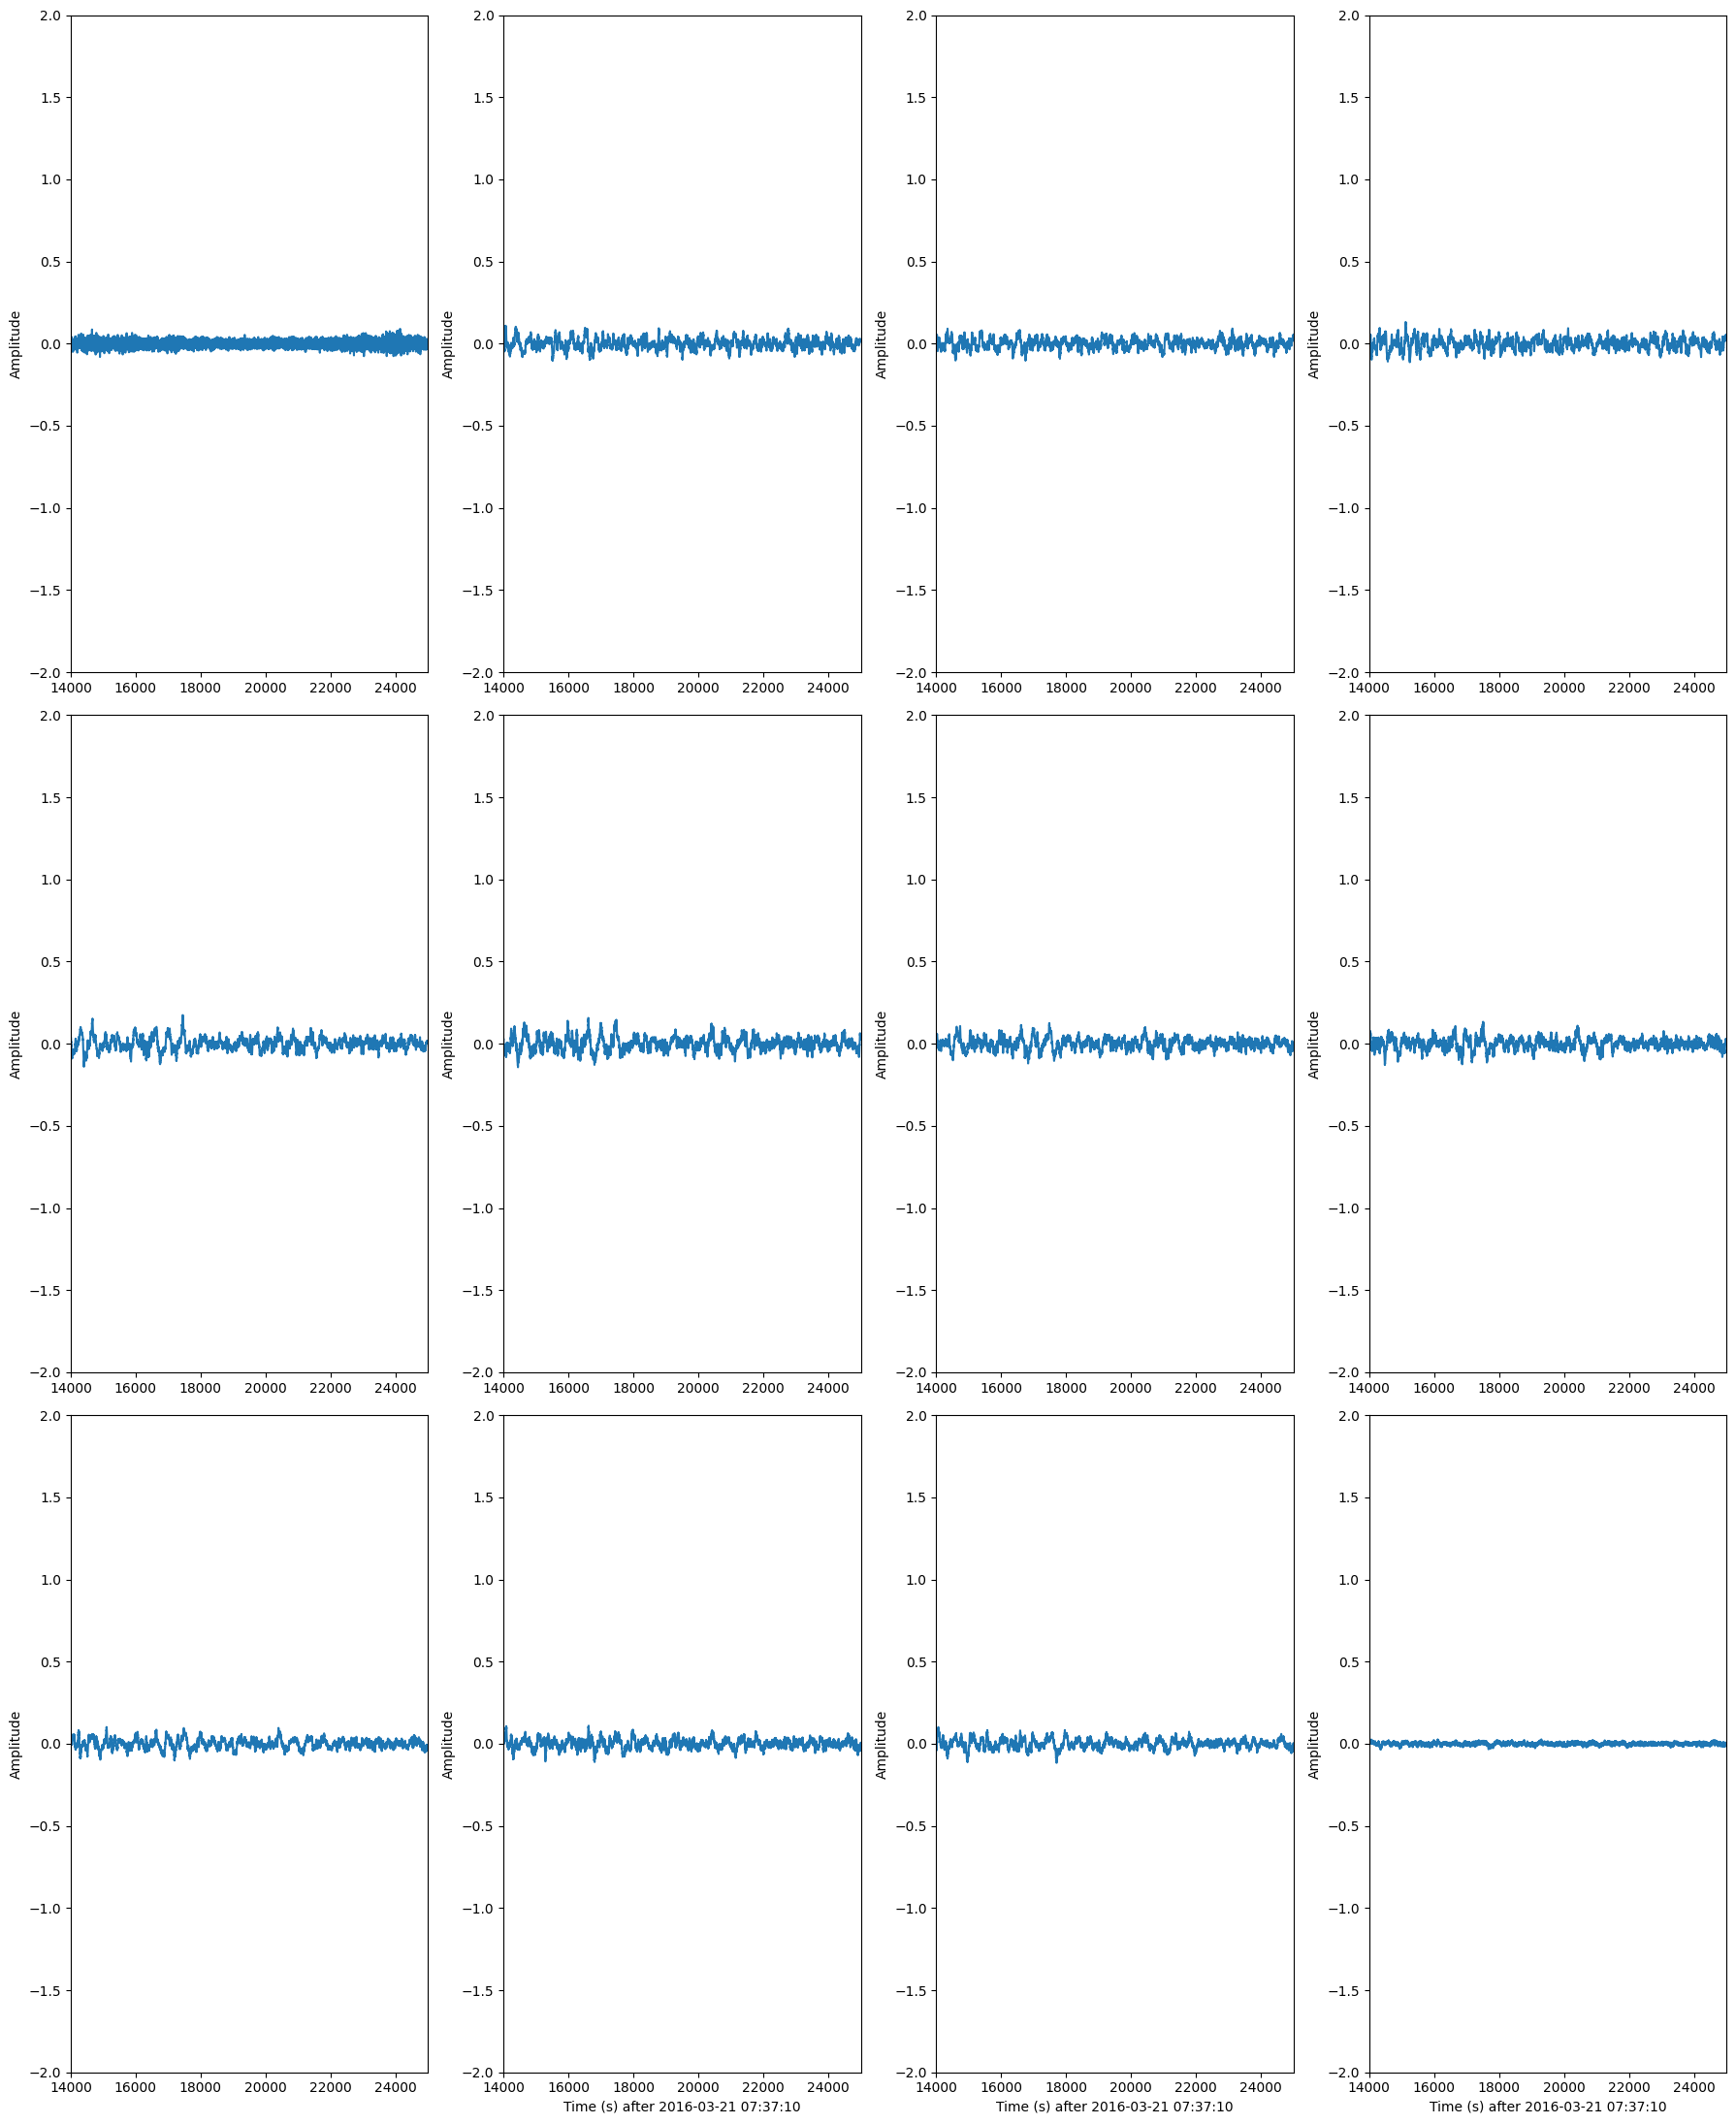

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to the HDF5 file
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Load data from HDF5 file
with h5py.File(file_path, 'r') as f:
    # Assuming data_stream is the relevant dataset
    data_stream = f['DasRawData/RawData'][:]
    # Adjust the following line to extract relevant metadata if needed
    # metadata = dict(f.attrs)

# Define parameters
trace_no = 0
start_trace = 40
trace_inc = 15
num_traces = 12
ylim = [-2, 2]
xlim = [14000, 25000]

# Prepare traces
traces = []
for index in range(num_traces):
    traces.append(data_stream[:, start_trace + trace_inc * index])

# Plotting
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(18, 22))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for ax, trace in zip(axes, traces):
    ax.plot(trace)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Amplitude')

ax10.set_xlabel('Time (s) after 2016-03-21 07:37:10')
ax11.set_xlabel('Time (s) after 2016-03-21 07:37:10')
ax12.set_xlabel('Time (s) after 2016-03-21 07:37:10')

plt.tight_layout()
plt.show()


Loading: ./PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5
Full Dataset Properties:
    Data Shape:         (30000, 8721)
    t_end - t_start:    29999000000.00000000 s
    nt * dt_computer:   30000
    Timestamps:         [1458545871404309911 : 1458545901403309911] (29999000000.00s)
    Times (UTC):        [Invalid timestamps]
    Distance:           [0.0 : 8720.0] m
Loading data slice:
    Data Shape:         (50, 4900)
    t_end - t_start:    49000000.00000000 s
    nt * dt_computer:   50
    Timestamps:         [1458545872404309911 : 1458545872453309911] (49000000.00s)
    Times (UTC):        [Invalid timestamps]
    Distance:           [100.0 : 4999.0] m


C:\Users\badar\AppData\Local\Temp\ipykernel_14420\707599518.py:86: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  start_time_utc = datetime.utcfromtimestamp(time[0])
C:\Users\badar\AppData\Local\Temp\ipykernel_14420\707599518.py:129: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  start_time_utc = datetime.utcfromtimestamp(time[0])


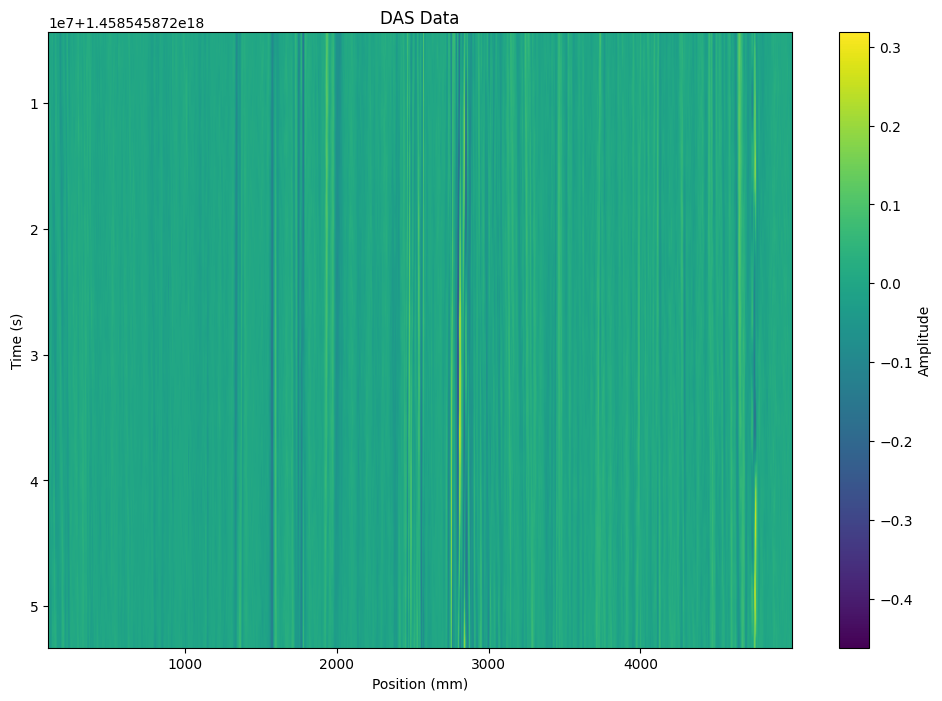

In [ ]:
### Set parameters ###############################################################

# Name of file to load
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Gauge length to apply if data is 'velocity' datatype
gauge_length = 2000  # (meters)

##########################################################################################


def load_hdf_slice(file, t_start=None, t_duration=None, x_start=None, x_stop=None, info=True):
    """
        Loads data and metadata from .hdf5 file. Optionally slices data in time and space.

        Args:
            file_path: hdf5 file path.
            t_start: Time from start of data to begin slice (s)
            t_duration: Length of desired data slice (s)
            x_start: Start fibre distance from front of Treble (m)
            x_stop: Stop fibre distance from front of Treble (m)

        Returns:
            data: Sliced data array.
            metadata: Attributes of hdf file.
            timestamps: Sliced timestamp vector.
            distances: Sliced distance vector.

        """
    print(f"Loading: {file}")

    with h5py.File(file, 'r') as f:
        # Load datasets
        raw_data = f['DasRawData/RawData'][:]
        if "DasRawData/DasTimeArray" in f.keys():
            time = f['DasRawData/DasTimeArray'][:]
        else:
            print("Using Computer Time, either because no GPS data was recorded or this is a re-saved dataset.")
            time = np.arange(raw_data.shape[0])

        md = dict(f.attrs)  # Load metadata attributes
        
        # Handle missing 'dt_computer' attribute
        if 'dt_computer' in md:
            dt = md["dt_computer"]
        else:
            print("Warning: 'dt_computer' attribute not found. Using default value of 1.")
            dt = 1
        
        # Handle missing 'dx' attribute
        if 'dx' in md:
            dx = md["dx"]
        else:
            print("Warning: 'dx' attribute not found. Using default value of 1.")
            dx = 1
        
        # Handle missing 'nx' attribute
        if 'nx' in md:
            nx = md["nx"]
        else:
            print("Warning: 'nx' attribute not found. Using default value based on data shape.")
            nx = raw_data.shape[1]
        
        # Handle missing 'sensing_range_start' attribute
        if 'sensing_range_start' in md:
            sensing_range_start = md["sensing_range_start"]
        else:
            print("Warning: 'sensing_range_start' attribute not found. Using default value of 0.")
            sensing_range_start = 0

        x = np.arange(nx) * dx + sensing_range_start

        if info:
            # Prints dimensions of full data
            print("Full Dataset Properties:")
            print(f"    Data Shape:         {raw_data.shape}")
            print(f"    t_end - t_start:    {time[-1]-time[0]:.8f} s")
            print(f"    nt * dt_computer:   {time.shape[0] * dt}")
            print(f"    Timestamps:         [{time[0]} : {time[-1]}] ({time[-1] - time[0]:.2f}s)")
            try:
                start_time_utc = datetime.utcfromtimestamp(time[0])
                end_time_utc = datetime.utcfromtimestamp(time[-1])
                print(f"    Times (UTC):        [{start_time_utc} : {end_time_utc}]")
            except (OSError, OverflowError, ValueError):
                print("    Times (UTC):        [Invalid timestamps]")
            print(f"    Distance:           [{x[0]:.1f} : {x[-1]:.1f}] m")

        # Calculate slice boundaries in samples
        if t_start:
            t1 = int(t_start / dt)
        else:
            t1 = 0
        if t_duration:
            t2 = t1 + int(t_duration / dt)
            # Enforce limit on end of data.
            if t2 > len(time):
                t2 = len(time)
        else:
            t2 = None

        if x_start:
            x1 = int((x_start - sensing_range_start) / dx)
        else:
            x1 = None
        if x_stop:
            x2 = int((x_stop - sensing_range_start) / dx)
        else:
            x2 = None

        # Slice data in space and time.
        # Only the slice of data is loaded into memory
        data = raw_data[t1:t2, x1:x2]
        time = time[t1:t2]
        x = x[x1:x2]

        if info:
            # Prints dimensions of sliced output data
            print("Loading data slice:")
            print(f"    Data Shape:         {data.shape}")
            print(f"    t_end - t_start:    {time[-1]-time[0]:.8f} s")
            print(f"    nt * dt_computer:   {time.shape[0] * dt}")
            print(f"    Timestamps:         [{time[0]} : {time[-1]}] ({time[-1] - time[0]:.2f}s)")
            try:
                start_time_utc = datetime.utcfromtimestamp(time[0])
                end_time_utc = datetime.utcfromtimestamp(time[-1])
                print(f"    Times (UTC):        [{start_time_utc} : {end_time_utc}]")
            except (OSError, OverflowError, ValueError):
                print("    Times (UTC):        [Invalid timestamps]")
            print(f"    Distance:           [{x[0]:.1f} : {x[-1]:.1f}] m")
        
        return data, md, time, x


# Load data using the function
data, metadata, t, x = load_hdf_slice (file_path, 
                                      t_start=1000, 
                                      t_duration=50, 
                                      x_start=100, 
                                      x_stop=5000)

# Plot the data
plt.figure(figsize=(12, 8))
plt.imshow(data, aspect='auto', extent=[x[0], x[-1], t[-1], t[0]])
plt.colorbar(label='Amplitude')
plt.xlabel('Position (mm)')
plt.ylabel('Time (s)')
plt.title('DAS Data')
plt.show()



Loading: ./PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5
Full Dataset Properties:
    Data Shape:         (30000, 8721)
    t_end - t_start:    29999000000.00000000 s
    nt * dt_computer:   30000
    Timestamps:         [1458545871404310016.00 : 1458545901403309824.00] (29999000000.00s)
    Times (UTC):        [2016-03-21 07:37:51.404310+00:00 : 2016-03-21 07:38:21.403310+00:00]
    Distance:           [0.0 : 8720.0] m
Loading data slice:
    Data Shape:         (25, 5000)
    t_end - t_start:    24000000.00000000 s
    nt * dt_computer:   25
    Times (UTC):        [2016-03-21 07:37:51.454310+00:00 : 2016-03-21 07:37:51.478310+00:00]
    Distance:           [0.0 : 4999.0] m


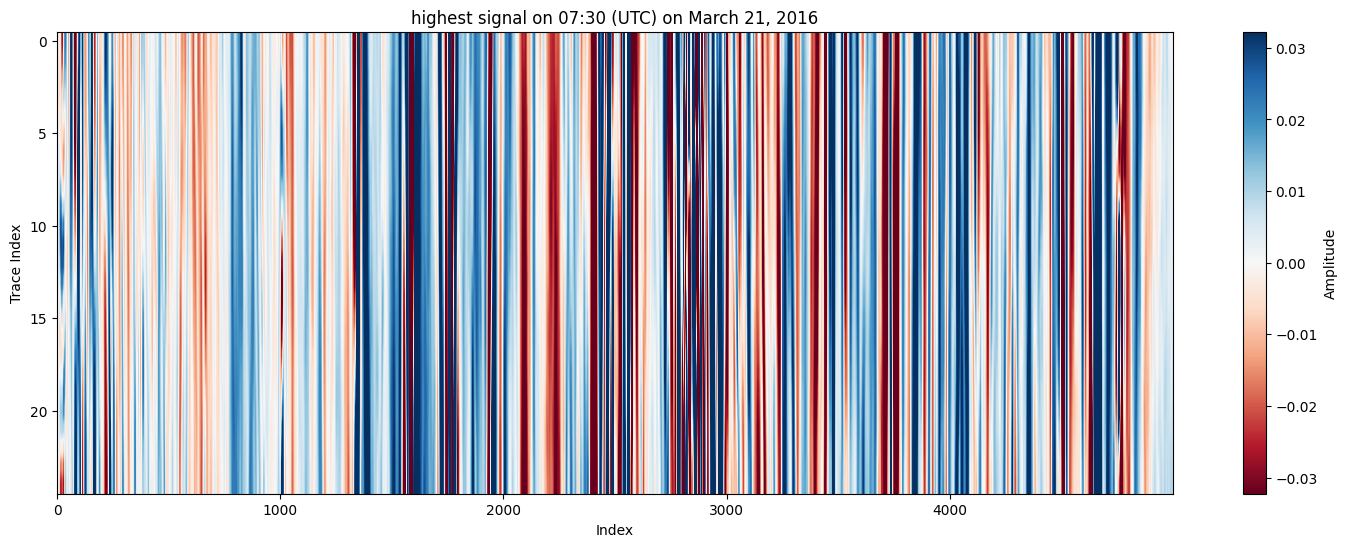

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Function to load HDF5 data
def load_hdf_slice(file, t_start=None, t_duration=None, x_start=None, x_stop=None, info=True):
    """
    Loads data and metadata from .hdf5 file. Optionally slices data in time and space.

    Args:
        file: hdf5 file path.
        t_start: Time from start of data to begin slice (s)
        t_duration: Length of desired data slice (s)
        x_start: Start fibre distance from front of Treble (m)
        x_stop: Stop fibre distance from front of Treble (m)

    Returns:
        data: Sliced data array.
        metadata: Attributes of hdf file.
        timestamps: Sliced timestamp vector.
        distances: Sliced distance vector.
    """
    print(f"Loading: {file}")

    with h5py.File(file, 'r') as f:
        # Load datasets
        raw_data = f['DasRawData/RawData'][:]
        time = f['DasRawData/DasTimeArray'][:]

        md = dict(f.attrs)  # Load metadata attributes
        dt = md.get("dt_computer", 1)
        dx = md.get("dx", 1)
        nx = md.get("nx", raw_data.shape[1])
        sensing_range_start = md.get("sensing_range_start", 0)
        x = np.arange(nx) * dx + sensing_range_start

        if info:
            print("Full Dataset Properties:")
            print(f"    Data Shape:         {raw_data.shape}")
            print(f"    t_end - t_start:    {time[-1] - time[0]:.8f} s")
            print(f"    nt * dt_computer:   {time.shape[0] * dt}")
            print(f"    Timestamps:         [{time[0]:.2f} : {time[-1]:.2f}] ({time[-1] - time[0]:.2f}s)")
            try:
                start_time_utc = datetime.fromtimestamp(time[0] / 1e9, timezone.utc)
                end_time_utc = datetime.fromtimestamp(time[-1] / 1e9, timezone.utc)
                print(f"    Times (UTC):        [{start_time_utc} : {end_time_utc}]")
            except OSError as e:
                print(f"    Times (UTC):        [Invalid timestamps: {e}]")
            print(f"    Distance:           [{x[0]:.1f} : {x[-1]:.1f}] m")

        # Calculate slice boundaries in samples
        t1 = int(t_start / dt) if t_start else 0
        t2 = t1 + int(t_duration / dt) if t_duration else None
        if t2 and t2 > len(time):
            t2 = len(time)

        x1 = int((x_start - sensing_range_start) / dx) if x_start else None
        x2 = int((x_stop - sensing_range_start) / dx) if x_stop else None

        # Slice data in space and time.
        data = raw_data[t1:t2, x1:x2]
        time = time[t1:t2]
        x = x[x1:x2]

        if info:
            print("Loading data slice:")
            print(f"    Data Shape:         {data.shape}")
            print(f"    t_end - t_start:    {time[-1] - time[0]:.8f} s")
            print(f"    nt * dt_computer:   {time.shape[0] * dt}")
            try:
                start_time_utc = datetime.fromtimestamp(time[0] / 1e9, timezone.utc)
                end_time_utc = datetime.fromtimestamp(time[-1] / 1e9, timezone.utc)
                print(f"    Times (UTC):        [{start_time_utc} : {end_time_utc}]")
            except OSError as e:
                print(f"    Times (UTC):        [Invalid timestamps: {e}]")
            print(f"    Distance:           [{x[0]:.1f} : {x[-1]:.1f}] m")

        return data, md, time, x

# Load data using the function
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'
data, metadata, t, x = load_hdf_slice(file_path, 
                                      t_start=50, 
                                      t_duration=25, 
                                      x_start=0, 
                                      x_stop= 5000)

# Apply Gaussian filter to the data
filtered_data = gaussian_filter(data, sigma=2)

vm0 = np.mean(filtered_data)
std0 = np.std(filtered_data)

# Plot the data
plt.figure(figsize=(18, 6))
event = plt.imshow(filtered_data, cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(event, label='Amplitude')
plt.title('highest signal on 07:30 (UTC) on March 21, 2016')
plt.xlabel('Index')
plt.ylabel('Trace Index')
plt.show()


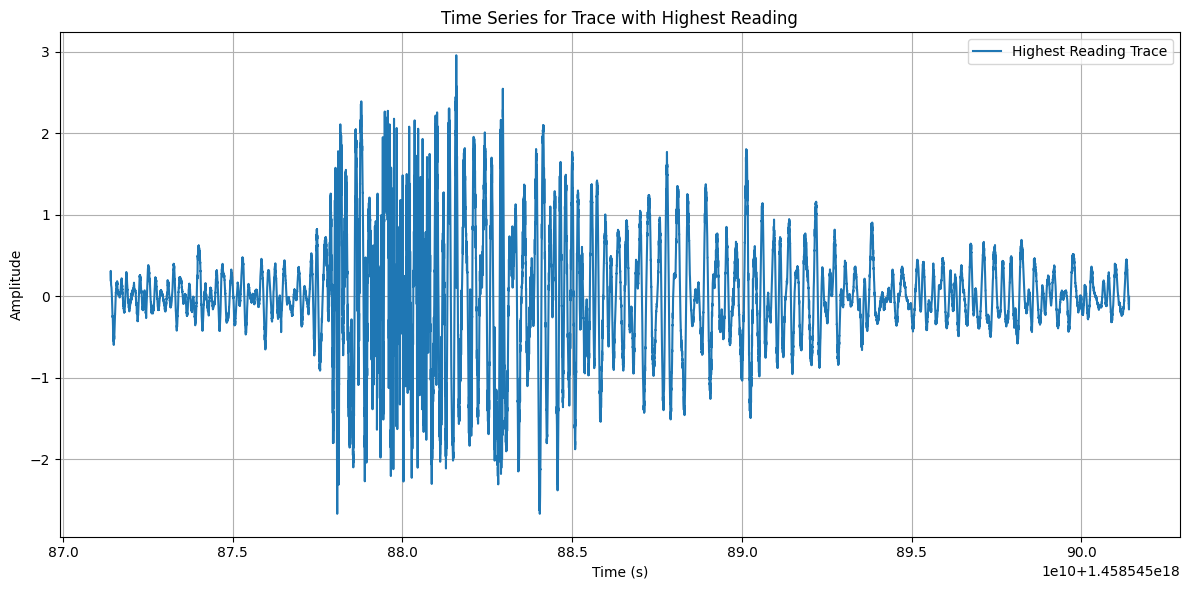

In [7]:
# Load data from HDF5 file
with h5py.File(file_path, 'r') as f:
    # Load datasets
    data_stream = f['DasRawData/RawData'][:]
    time_array = f['DasRawData/DasTimeArray'][:]

# Find index of maximum value in data_stream
max_value_index = np.unravel_index(np.argmax(data_stream, axis=None), data_stream.shape)

# Extract the trace with the highest reading
highest_trace = data_stream[:, max_value_index[1]]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(time_array, highest_trace, label='Highest Reading Trace')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Series for Trace with Highest Reading')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [8]:
#Determining Upper and Lower Limits of the Data
#In order to determine upper and lower bounds for the colorbar, the 99th percentile, maximum value, and standard deviation are calculated

with h5py.File(file_path, 'r') as f:
    # Load datasets
    data_stream = f['DasRawData/RawData'][:]

# Calculate the 99th percentile, maximum value, and standard deviation
vm0 = np.percentile(data_stream, 99)
std0 = np.std(data_stream)
max_value = np.max(data_stream)

print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is {:.4f}".format(vm0, max_value, std0))

The 99th percentile is 0.3679; the max amplitude is 2.9594; the standard deviation is 0.1225


In [9]:
vm1 = np.percentile(data[1], 99)
std1 = np.std(data[1])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm1, data[1].max(),std1))


The 99th percentile is 0.8711; the max amplitude is 4.7832; the standard deviation is  0.3535


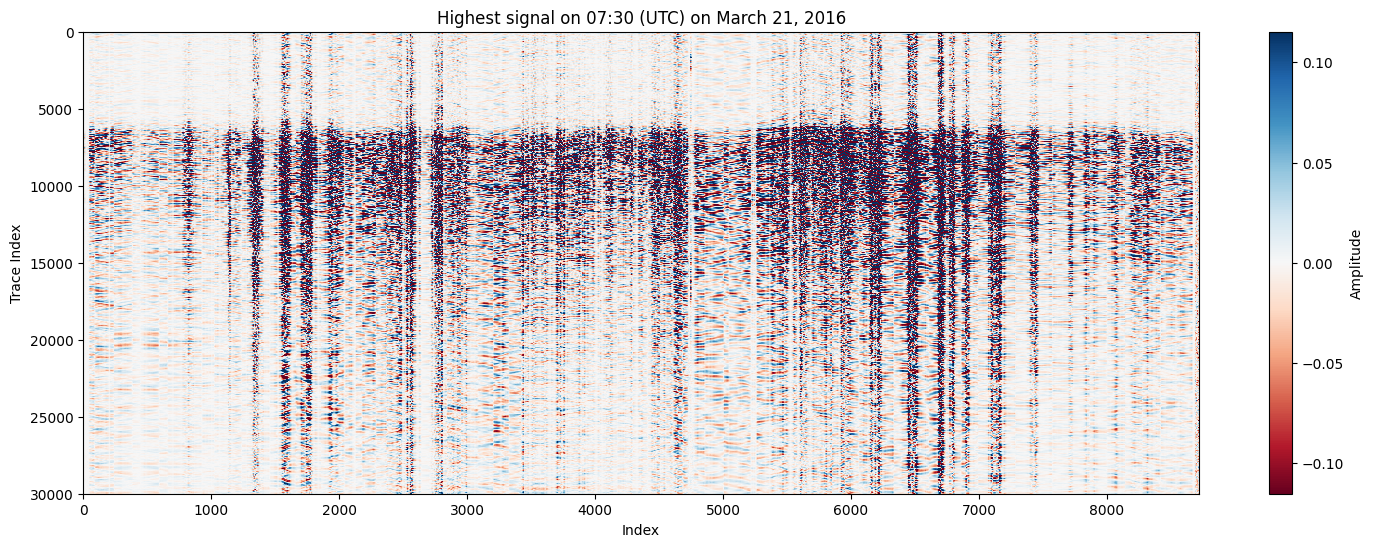

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Path to the HDF5 file
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Load data from HDF5 file
with h5py.File(file_path, 'r') as f:
    # Load datasets
    data = f['DasRawData/RawData'][:]

# Apply Gaussian filter to the data
filtered_data = gaussian_filter(data, sigma=2)

vm0 = np.mean(filtered_data)
std0 = np.std(filtered_data)

# Set xlim based on the dimensions of your data
xlim = [0, filtered_data.shape[1]]

plt.figure(figsize=(18, 6))
event = plt.imshow(filtered_data, cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.xlim(xlim)
plt.ylim(filtered_data.shape[0], 0)  # Adjusting to show relevant traces in reverse order (0 at the top)

plt.colorbar(event, label='Amplitude')
plt.title('Highest signal on 07:30 (UTC) on March 21, 2016')
plt.xlabel('Index')
plt.ylabel('Trace Index')
plt.show()


In [5]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load data from HDF5 file
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

with h5py.File(file_path, 'r') as f:
    data = f['DasRawData/RawData'][:]

# Example: Create dummy labels for classification (replace with actual labels)
num_classes = 10
labels = np.random.randint(0, num_classes, data.shape[0])

# Normalize the data
data = (data - np.mean(data)) / np.std(data)

# Reshape data if necessary for CNN/VGG16
data = data.reshape(-1, data.shape[1], 1)  # Example reshape for 1D CNN

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


Loading: ./PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5
Full Dataset Properties:
    Data Shape:         (30000, 8721)
    t_end - t_start:    29999000000.00000000 s
    nt * dt_computer:   30000
    Timestamps:         [1458545871404310016.00 : 1458545901403309824.00] (29999000000.00s)
    Times (UTC):        [2016-03-21 07:37:51.404310+00:00 : 2016-03-21 07:38:21.403310+00:00]
    Distance:           [0.0 : 8720.0] m
Loading data slice:
    Data Shape:         (25, 500)
    t_end - t_start:    24000000.00000000 s
    nt * dt_computer:   25
    Times (UTC):        [2016-03-21 07:37:51.404310+00:00 : 2016-03-21 07:37:51.428310+00:00]
    Distance:           [0.0 : 499.0] m


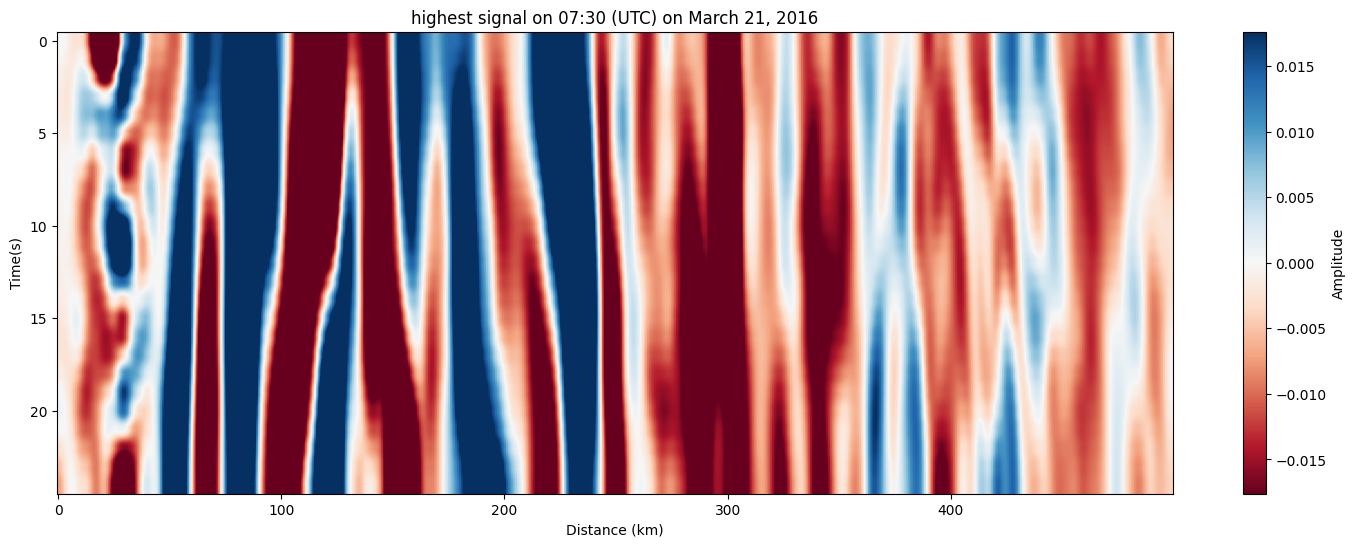

In [38]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Function to load HDF5 data
def load_hdf_slice(file, t_start=None, t_duration=None, x_start=None, x_stop=None, info=True):
    """
    Loads data and metadata from .hdf5 file. Optionally slices data in time and space.

    Args:
        file: hdf5 file path.
        t_start: Time from start of data to begin slice (s)
        t_duration: Length of desired data slice (s)
        x_start: Start fibre distance from front of Treble (m)
        x_stop: Stop fibre distance from front of Treble (m)

    Returns:
        data: Sliced data array.
        metadata: Attributes of hdf file.
        timestamps: Sliced timestamp vector.
        distances: Sliced distance vector.
    """
    print(f"Loading: {file}")

    with h5py.File(file, 'r') as f:
        # Load datasets
        raw_data = f['DasRawData/RawData'][:]
        time = f['DasRawData/DasTimeArray'][:]

        md = dict(f.attrs)  # Load metadata attributes
        dt = md.get("dt_computer", 1)
        dx = md.get("dx", 1)
        nx = md.get("nx", raw_data.shape[1])
        sensing_range_start = md.get("sensing_range_start", 0)
        x = np.arange(nx) * dx + sensing_range_start

        if info:
            print("Full Dataset Properties:")
            print(f"    Data Shape:         {raw_data.shape}")
            print(f"    t_end - t_start:    {time[-1] - time[0]:.8f} s")
            print(f"    nt * dt_computer:   {time.shape[0] * dt}")
            print(f"    Timestamps:         [{time[0]:.2f} : {time[-1]:.2f}] ({time[-1] - time[0]:.2f}s)")
            try:
                start_time_utc = datetime.fromtimestamp(time[0] / 1e9, timezone.utc)
                end_time_utc = datetime.fromtimestamp(time[-1] / 1e9, timezone.utc)
                print(f"    Times (UTC):        [{start_time_utc} : {end_time_utc}]")
            except OSError as e:
                print(f"    Times (UTC):        [Invalid timestamps: {e}]")
            print(f"    Distance:           [{x[0]:.1f} : {x[-1]:.1f}] m")

        # Calculate slice boundaries in samples
        t1 = int(t_start / dt) if t_start else 0
        t2 = t1 + int(t_duration / dt) if t_duration else None
        if t2 and t2 > len(time):
            t2 = len(time)

        x1 = int((x_start - sensing_range_start) / dx) if x_start else None
        x2 = int((x_stop - sensing_range_start) / dx) if x_stop else None

        # Slice data in space and time.
        data = raw_data[t1:t2, x1:x2]
        time = time[t1:t2]
        x = x[x1:x2]

        if info:
            print("Loading data slice:")
            print(f"    Data Shape:         {data.shape}")
            print(f"    t_end - t_start:    {time[-1] - time[0]:.8f} s")
            print(f"    nt * dt_computer:   {time.shape[0] * dt}")
            try:
                start_time_utc = datetime.fromtimestamp(time[0] / 1e9, timezone.utc)
                end_time_utc = datetime.fromtimestamp(time[-1] / 1e9, timezone.utc)
                print(f"    Times (UTC):        [{start_time_utc} : {end_time_utc}]")
            except OSError as e:
                print(f"    Times (UTC):        [Invalid timestamps: {e}]")
            print(f"    Distance:           [{x[0]:.1f} : {x[-1]:.1f}] m")

        return data, md, time, x

# Load data using the function
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'
data, metadata, t, x = load_hdf_slice(file_path, t_start=0, t_duration=25, x_start=0, x_stop=500)

# Apply Gaussian filter to the data
filtered_data = gaussian_filter(data, sigma=2)

vm0 = np.mean(filtered_data)
std0 = np.std(filtered_data)

# Plot the data
plt.figure(figsize=(18, 6))
event = plt.imshow(filtered_data, cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(event, label='Amplitude')
plt.title('highest signal on 07:30 (UTC) on March 21, 2016')
plt.xlabel('Distance (km)')
plt.ylabel('Time(s)')
plt.show()


In [19]:
# Check shapes of data and labels
print(f"Shape of data: {data.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of data: (25, 500)
Shape of labels: (30000,)


In [20]:
import numpy as np

# Verify the shape of the data
print(f"Shape of data: {data.shape}")

# Generate new labels for demonstration purposes
labels = np.random.randint(0, 2, size=(25,))

# Verify the shape of the labels
print(f"Shape of labels: {labels.shape}")

# Now proceed with splitting the data
from sklearn.model_selection import train_test_split

X = data
y = labels

# Split data into training and remaining sets (80% train, 20% remaining)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, train_size=0.8, random_state=42)

# Split remaining data into validation and test sets (50% of remaining, which is 10% of total data)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, train_size=0.5, random_state=42)

# Reshape data to add a channel dimension (necessary for Conv1D)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalize data (assuming data values range from 0 to 255)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Print shapes to verify
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of data: (25, 500)
Shape of labels: (25,)
Shape of X_train: (20, 500, 1)
Shape of X_val: (2, 500, 1)
Shape of X_test: (3, 500, 1)
Shape of y_train: (20,)
Shape of y_val: (2,)
Shape of y_test: (3,)


In [1]:
#CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Build a CNN model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(data.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)


NameError: name 'data' is not defined

In [3]:
#VGG16 Model - preparation
import h5py
import numpy as np
import cv2

# Path to your HDF5 file
file_path = './PoroTomo DASH/PoroTomo_iDAS16043_160321073751.h5'

# Read the data from the HDF5 file
with h5py.File(file_path, 'r') as f:
    data = f['DasRawData/RawData'][:]
    labels = np.zeros(data.shape[0])  # Placeholder, replace with actual label loading if available

# Ensure we have the correct number of samples in labels
assert data.shape[0] == labels.shape[0], "Mismatch between data and labels"

# Preprocess the data: resize and convert to 3 channels
def resize_data(data):
    resized_data = []
    for sample in data:
        reshaped_sample = cv2.resize(sample.reshape(-1, 1), (50, 50))
        resized_sample = np.stack((reshaped_sample,) * 3, axis=-1)
        resized_data.append(resized_sample)
    return np.array(resized_data)

# Assuming data has shape (30000, 8721), adjust as necessary
X_resized = resize_data(data[:30000])  # Ensure we only take 30000 samples to match labels

# Normalize the data
X_resized = X_resized.astype('float32') / 255.0

# Ensure labels match the number of data samples
y = labels[:30000]

# Check the final shapes
print("Shape of X_resized:", X_resized.shape)  # Expected: (30000, 50, 50, 3)
print("Shape of y:", y.shape)  # Expected: (30000,)

Shape of X_resized: (30000, 50, 50, 3)
Shape of y: (30000,)


In [3]:
#Training, Validation and Test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, y, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)  # Expected: (24000, 50, 50, 3)
print("Shape of X_val:", X_val.shape)  # Expected: (3000, 50, 50, 3)
print("Shape of X_test:", X_test.shape)  # Expected: (3000, 50, 50, 3)


NameError: name 'X_resized' is not defined

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for data augmentation
VGG_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your data (if necessary)
VGG_datagen.fit(X_train)

# Train the model using the data generator
history = model.fit(VGG_datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Make predictions
predictions = model.predict(X_test)


NameError: name 'X_train' is not defined

In [28]:
#HYbrid CNN-LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D

# Flatten data if necessary
data_reshaped = data.reshape(data.shape[0], data.shape[1], 1)

# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_remaining, y_train, y_remaining = train_test_split(data_reshaped, labels, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, train_size=0.5, random_state=42)

# Define the hybrid CNN-LSTM model
hyb_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(data_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
hyb_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = hyb_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on test data
test_loss, test_acc = hyb_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Make predictions
predictions = hyb_model.predict(X_test)



c:\Users\badar\Desktop\VS Studio\Deep Learning\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


KeyboardInterrupt: 

In [ ]:
# Check the shapes of the test data and predictions
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred_RNN: {y_pred_RNN.shape}")
print(f"Shape of y_pred_LSTM: {y_pred_LSTM.shape}")
print(f"Shape of y_pred_GRU: {y_pred_GRU.shape}")

# Ensure that y_test and the predictions have the same number of samples
y_test = y_test[:min(len(y_test), len(y_pred_RNN), len(y_pred_LSTM), len(y_pred_GRU))]
y_pred_RNN = y_pred_RNN[:len(y_test)]
y_pred_LSTM = y_pred_LSTM[:len(y_test)]
y_pred_GRU = y_pred_GRU[:len(y_test)]

# Flatten the predictions and y_test if necessary
y_test_flattened = y_test.flatten()
y_pred_RNN_flattened = y_pred_RNN.flatten()
y_pred_LSTM_flattened = y_pred_LSTM.flatten()
y_pred_GRU_flattened = y_pred_GRU.flatten()

# Verify that the shapes match after trimming and flattening
print(f"Shape of y_test_flattened: {y_test_flattened.shape}")
print(f"Shape of y_pred_RNN_flattened: {y_pred_RNN_flattened.shape}")
print(f"Shape of y_pred_LSTM_flattened: {y_pred_LSTM_flattened.shape}")
print(f"Shape of y_pred_GRU_flattened: {y_pred_GRU_flattened.shape}")

# Calculate MAE
rnn_mae = mean_absolute_error(y_test_flattened, y_pred_RNN_flattened)
lstm_mae = mean_absolute_error(y_test_flattened, y_pred_LSTM_flattened)
gru_mae = mean_absolute_error(y_test_flattened, y_pred_GRU_flattened)

print(f"RNN MAE: {rnn_mae}")
print(f"LSTM MAE: {lstm_mae}")
print(f"GRU MAE: {gru_mae}")